# Training the Model

This notebook builds a classification model to predict the outcome of football matches using engineered features from historical team performance data. The model is trained using CatBoost, a gradient boosting algorithm that handles missing values and categorical features natively. The goal is to classify match results as home win, away win, or draw based on team strength, form, and other match statistics.

### Imports

In [11]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint

match_data = pd.read_csv("../data/training_data.csv")

match_data=match_data.drop(columns=['DATE'],axis=1)

print(match_data.dtypes)
print(match_data.columns.tolist())
match_data.head()

HOME_TEAM                      object
HOME_STRENGTH                 float64
HOME_LEAGUE_STRENGTH          float64
HOME_GOALS_FOR_LAST3          float64
HOME_GOALS_AGAINST_LAST3      float64
HOME_STRENGTH_LAST3           float64
HOME_LEAGUE_STRENGTH_LAST3    float64
HOME_TARGET_LAST3             float64
HOME_FOULS_LAST3              float64
HOME_CORNERS_LAST3            float64
HOME_YELLOW_LAST3             float64
HOME_RED_LAST3                float64
HOME_FORM_LAST3               float64
AWAY_TEAM                      object
AWAY_STRENGTH                 float64
AWAY_LEAGUE_STRENGTH          float64
AWAY_GOALS_FOR_LAST3          float64
AWAY_GOALS_AGAINST_LAST3      float64
AWAY_STRENGTH_LAST3           float64
AWAY_LEAGUE_STRENGTH_LAST3    float64
AWAY_TARGET_LAST3             float64
AWAY_FOULS_LAST3              float64
AWAY_CORNERS_LAST3            float64
AWAY_YELLOW_LAST3             float64
AWAY_RED_LAST3                float64
AWAY_FORM_LAST3               float64
RESULT      

,HOME_TEAM,HOME_STRENGTH,HOME_LEAGUE_STRENGTH,HOME_GOALS_FOR_LAST3,HOME_GOALS_AGAINST_LAST3,HOME_STRENGTH_LAST3,HOME_LEAGUE_STRENGTH_LAST3,HOME_TARGET_LAST3,HOME_FOULS_LAST3,HOME_CORNERS_LAST3,...,AWAY_YELLOW_LAST3,AWAY_RED_LAST3,AWAY_FORM_LAST3,RESULT,STRENGTH_DIFF,LEAGUE_STRENGTH_DIFF,FORM_DIFF,HOME_GOAL_DIFF_LAST3,AWAY_GOAL_DIFF_LAST3,TOTAL_GOALS
0,AFC Ajax,84.3,76.2,3.000000,0.666667,84.3,76.2,NaN,NaN,NaN,...,NaN,NaN,3.0,H,-4.5,-2.4,0.0,2.333333,2.000000,6.0
1,AFC Ajax,84.3,76.2,2.666667,1.666667,84.3,76.2,NaN,NaN,NaN,...,2.000000,0.333333,3.0,A,-4.7,-2.4,0.0,1.000000,1.333333,1.0
2,AVS,75.7,78.6,1.333333,2.000000,75.7,78.6,3.000000,12.000000,2.666667,...,1.000000,0.333333,4.0,H,-2.6,0.0,0.0,-0.666667,0.000000,1.0
3,AVS,75.7,78.6,0.666667,1.666667,75.7,78.6,1.666667,11.333333,2.333333,...,2.333333,0.000000,7.0,D,-0.4,0.0,0.0,-1.000000,-1.333333,0.0
4,AVS,75.7,78.6,0.333333,1.333333,75.7,78.6,1.000000,12.666667,4.666667,...,2.666667,0.000000,1.0,A,-8.5,0.0,0.0,-1.000000,2.666667,5.0


### Set Target and Categorical Features

In [12]:
# Define target and features
target_col = "RESULT"
categorical_cols = ["HOME_TEAM", "AWAY_TEAM"]

X = match_data.drop(columns=[target_col,"TOTAL_GOALS"])
y = match_data[target_col]

### Training Testing Split

In [13]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Create CatBoost Pool objects for better performance
train_pool = Pool(X_train, y_train, cat_features=categorical_cols)
test_pool = Pool(X_test, y_test, cat_features=categorical_cols)

### Train Model

In [14]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    verbose=100,
    random_seed=42
)

model.fit(train_pool, eval_set=test_pool)


0:	learn: 0.5003794	test: 0.5052762	best: 0.5052762 (0)	total: 46.2ms	remaining: 23.1s
100:	learn: 0.5205215	test: 0.5170701	best: 0.5176909 (19)	total: 6.01s	remaining: 23.7s
200:	learn: 0.5319721	test: 0.5226567	best: 0.5232775 (178)	total: 11.4s	remaining: 17s
300:	learn: 0.5497689	test: 0.5257604	best: 0.5276226 (264)	total: 17.5s	remaining: 11.6s
400:	learn: 0.5626681	test: 0.5251397	best: 0.5288641 (336)	total: 23.9s	remaining: 5.91s
499:	learn: 0.5768780	test: 0.5220360	best: 0.5288641 (336)	total: 30.3s	remaining: 0us

bestTest = 0.5288640596
bestIteration = 336

Shrink model to first 337 iterations.


### Feature Selection

As we can see, that the Accuracy is around 50% which is the same as random guess. So now we should try to possibly reduce the number of features that may be resulting in the model getting confused.

,Feature Id,Importances
0,STRENGTH_DIFF,19.155643
1,HOME_TEAM,15.309581
2,AWAY_TEAM,14.960351
3,AWAY_STRENGTH_LAST3,3.266055
4,HOME_GOAL_DIFF_LAST3,2.916050
5,AWAY_GOALS_FOR_LAST3,2.909969
6,AWAY_GOAL_DIFF_LAST3,2.877180
7,AWAY_GOALS_AGAINST_LAST3,2.663527
8,HOME_STRENGTH,2.561767
9,HOME_GOALS_FOR_LAST3,2.429438


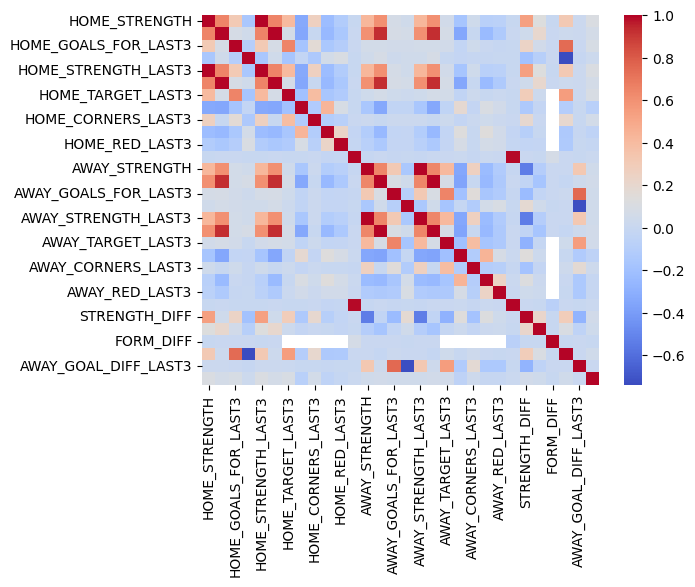

In [15]:
model.get_feature_importance(prettified=True)

numeric_data = match_data.select_dtypes(include=["number"])
sns.heatmap(numeric_data.corr(), annot=False, cmap='coolwarm')

model.get_feature_importance(prettified=True)

### Train a New Model, With Subset of Features

I am also going to change the target, as two-level classification is easier than three-level. So the outcomes will now be Home Win or No Home Win

In [16]:
drop_cols = [
    "HOME_YELLOW_LAST3",
    "HOME_CORNERS_LAST3",
    "AWAY_CORNERS_LAST3",
    "AWAY_YELLOW_LAST3",
    "HOME_FOULS_LAST3",
    "AWAY_FOULS_LAST3",
    "AWAY_RED_LAST3",
    "HOME_RED_LAST3",
    "FORM_DIFF",

]

# Create binary label: 1 if home team wins, 0 otherwise
match_data['HOME_WIN'] = match_data['RESULT'].apply(lambda x: 1 if x == 'H' else 0)

# Create a new dataframe without those columns + columns to exclude like teams, date, home win
X = match_data.drop(columns=drop_cols + ["HOME_TEAM", "AWAY_TEAM", "HOME_WIN","TOTAL_GOALS","RESULT"])

# Target column
y = match_data["HOME_WIN"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# Initialize and train model
model = CatBoostClassifier(iterations=500, eval_metric='Accuracy', random_seed=42, verbose=100)
model.fit(train_pool, eval_set=test_pool, use_best_model=True)

# Evaluate
y_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Learning rate set to 0.082926
0:	learn: 0.6268193	test: 0.6188703	best: 0.6188703 (0)	total: 9.88ms	remaining: 4.93s
100:	learn: 0.6637925	test: 0.6350093	best: 0.6350093 (68)	total: 805ms	remaining: 3.18s
200:	learn: 0.6859350	test: 0.6362508	best: 0.6405959 (189)	total: 1.65s	remaining: 2.45s
300:	learn: 0.7074567	test: 0.6393544	best: 0.6405959 (189)	total: 2.8s	remaining: 1.85s
400:	learn: 0.7288404	test: 0.6399752	best: 0.6424581 (302)	total: 3.93s	remaining: 969ms
499:	learn: 0.7482238	test: 0.6312849	best: 0.6424581 (302)	total: 5.02s	remaining: 0us

bestTest = 0.6424581006
bestIteration = 302

Shrink model to first 303 iterations.
Test Accuracy: 0.6424581005586593
              precision    recall  f1-score   support

           0       0.66      0.76      0.71       911
           1       0.61      0.49      0.54       700

    accuracy                           0.64      1611
   macro avg       0.63      0.62      0.62      1611
weighted avg       0.64      0.64      0.64    

### Tune the Parameters of the Model

Now that we have achieved a higher accuracy by trying out different parameters to which achieves the highest accuracy

In [17]:
param_dist = {
    'iterations': [300, 500, 700],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1],
    'random_strength': [1, 5, 10],
    'border_count': [32, 64, 128]
}

model = CatBoostClassifier(
    eval_metric='Accuracy',
    random_seed=42,
    verbose=0
)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter combinations to try
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:")
print(random_search.best_params_)

print("\nBest Cross-Validation Accuracy:")
print(random_search.best_score_)

# Use the best model to predict on test set
result_classifier = random_search.best_estimator_
y_pred = result_classifier.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
importances = result_classifier.get_feature_importance()
feature_names = X.columns

# Combine into a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters:
{'random_strength': 5, 'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 4, 'border_count': 128, 'bagging_temperature': 1}

Best Cross-Validation Accuracy:
0.6411665779416621

Test Accuracy: 0.6412166356300435
              precision    recall  f1-score   support

           0       0.66      0.76      0.71       911
           1       0.61      0.49      0.54       700

    accuracy                           0.64      1611
   macro avg       0.63      0.62      0.62      1611
weighted avg       0.64      0.64      0.63      1611

                       Feature  Importance
16               STRENGTH_DIFF   33.270291
17        LEAGUE_STRENGTH_DIFF    5.917626
0                HOME_STRENGTH    5.169570
10        AWAY_GOALS_FOR_LAST3    5.106117
4          HOME_STRENGTH_LAST3    4.829558
8                AWAY_STRENGTH    4.384075
2         HOME_GOALS_FOR_LAST3    4.178980
12         AWAY_STRENG

## Number of Expected Goals Classifier

Since we already have a classifier to predict the outcome of each match, we can now make a different model to try and predict the number of expected goals for the upcoming matches. We will use the CatBoost Classifier again for this, the target for this model will be the `TOTAL_GOALS` column which we will convert into an `OVER_3_5` column. We will be predicting whether there will be over or under 3.5 goals in the match.

In [20]:
match_data['OVER_3_5'] = match_data['TOTAL_GOALS'].apply(lambda x: 1 if x > 3.5 else 0)

# Prepare data
drop_cols = [
    "RESULT", "HOME_TEAM", "AWAY_TEAM", "TOTAL_GOALS","FORM_DIFF","HOME_YELLOW_LAST3",
    "AWAY_YELLOW_LAST3","HOME_RED_LAST3","AWAY_RED_LAST3",
    "AWAY_FOULS_LAST3","HOME_FOULS_LAST3","HOME_WIN","OVER_3_5" # drop the regression target
]

X = match_data.drop(columns=drop_cols)
y = match_data["OVER_3_5"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

goals_classifier = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    eval_metric='Accuracy',
    random_seed=42,
    verbose=100
)

goals_classifier.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

y_pred = goals_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

importances = goals_classifier.get_feature_importance()
feature_names = X.columns

# Combine into a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

0:	learn: 0.7188422	test: 0.7181875	best: 0.7181875 (0)	total: 9.56ms	remaining: 4.77s
100:	learn: 0.7250504	test: 0.7212911	best: 0.7212911 (97)	total: 660ms	remaining: 2.61s
200:	learn: 0.7349061	test: 0.7184978	best: 0.7212911 (97)	total: 1.34s	remaining: 2s
300:	learn: 0.7467018	test: 0.7181875	best: 0.7212911 (97)	total: 2.03s	remaining: 1.34s
400:	learn: 0.7560919	test: 0.7175667	best: 0.7212911 (97)	total: 2.79s	remaining: 689ms
499:	learn: 0.7652491	test: 0.7184978	best: 0.7212911 (97)	total: 3.43s	remaining: 0us

bestTest = 0.7212911235
bestIteration = 97

Shrink model to first 98 iterations.
Accuracy: 0.7212911235257604
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2314
           1       0.81      0.01      0.03       908

    accuracy                           0.72      3222
   macro avg       0.77      0.51      0.43      3222
weighted avg       0.75      0.72      0.61      3222

                       Feature  Imp

As we see from the output, we are able to successfully predict whether the amount of goals in a game are more or less than 3.5 goals with about 72% accuracy. While this accuracy may not seem very high, football is very unpredictable, and being able just to get this level of accuracy is impressive.

### Save Models for Tournament Predictions

In [21]:
result_classifier.save_model("catboost_result_model.cbm")
goals_classifier.save_model("catboost_goals_model.cbm")